In [28]:
import pandas as pd
import re
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
import nltk
import matplotlib.pyplot as plt

# Загрузка необходимых ресурсов
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')  

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Prosc\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Prosc\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Prosc\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [29]:
# Загрузка данных
data_path = r'C:\Users\Prosc\PycharmProjects\NLP\tg_analitic\preprocessed.csv'
df = pd.read_csv(data_path, encoding='utf-8-sig')
df = df.dropna(subset=['text'])

df.head()

,text,date,hashtags
0,на московском тракте началось строительство но...,2024-12-10T11:49:04+00:00,NaN
1,совсем скоро 19 декабря в 1200 по московскому ...,2024-12-10T11:33:50+00:00,NaN
2,красная икра в тюмени подорожала почти в два р...,2024-12-10T11:08:29+00:00,NaN
3,сегодня произошло два дтп с автобусами в котор...,2024-12-10T10:51:46+00:00,NaN
4,в деревне копотилово казанского района открыли...,2024-12-10T10:01:36+00:00,NaN


In [30]:
# Функция для построения столбчатой диаграммы
def plot_bar_chart(data, title, xlabel, ylabel, color='blue', figsize=(5, 5)):
    plt.figure(figsize=figsize)
    data.plot(kind='bar', color=color, edgecolor='black')
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.xticks(rotation=0)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()



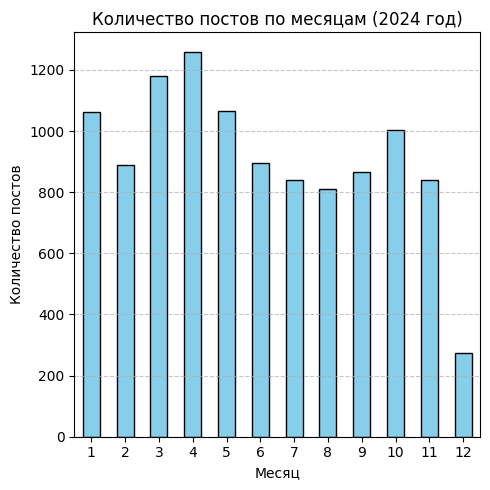

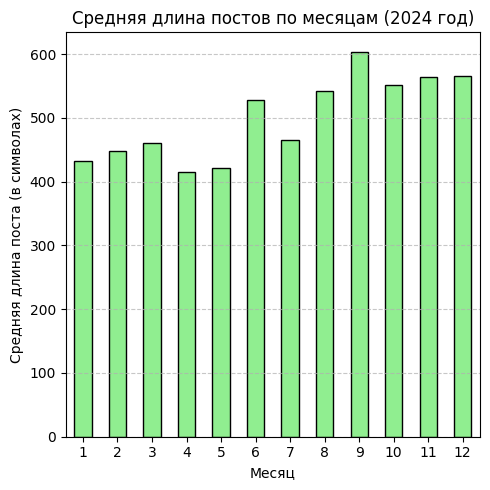

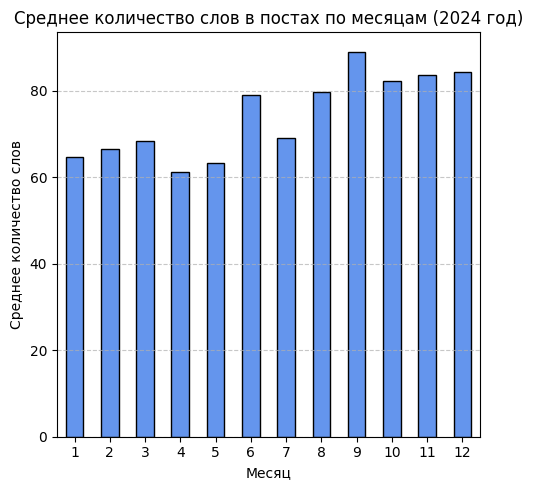

In [35]:
# Загрузка и предварительная обработка данных
df['date'] = pd.to_datetime(df['date'])  # Преобразование даты
df = df[df['date'].dt.year == 2024]  # Фильтрация по году
df['month'] = df['date'].dt.month  # Извлечение месяца

# Построение графика количества постов по месяцам
posts_per_month = df['month'].value_counts().sort_index()
plot_bar_chart(
    data=posts_per_month,
    title='Количество постов по месяцам (2024 год)',
    xlabel='Месяц',
    ylabel='Количество постов',
    color='skyblue'
)

# Средняя длина поста по месяцам
df['post_length'] = df['text'].str.len()  # Длина поста
average_length_per_month = df.groupby('month')['post_length'].mean()
plot_bar_chart(
    data=average_length_per_month,
    title='Средняя длина постов по месяцам (2024 год)',
    xlabel='Месяц',
    ylabel='Средняя длина поста (в символах)',
    color='lightgreen'
)

# Среднее количество слов по месяцам
df['word_count'] = df['text'].str.split().apply(len)  # Количество слов
average_word_count_per_month = df.groupby('month')['word_count'].mean()
plot_bar_chart(
    data=average_word_count_per_month,
    title='Среднее количество слов в постах по месяцам (2024 год)',
    xlabel='Месяц',
    ylabel='Среднее количество слов',
    color='cornflowerblue'
)


In [32]:
# Инициализация лемматизатора
lemmatizer = WordNetLemmatizer()

# Функция для очистки текста (токенизация, лемматизация и удаление стоп-слов)
def clean_text(text):
    if isinstance(text, str):
        text = text.lower()  # Приводим к нижнему регистру
        text = re.sub(r"[^a-zа-я\s]", "", text)  # Удаляем все не алфавитные символы
        tokens = word_tokenize(text)  # Токенизация
        stop_words = set(stopwords.words('russian'))  # Стоп-слова на русском
        # Лемматизация и удаление стоп-слов
        tokens = [lemmatizer.lemmatize(word) for word in tokens if word not in stop_words]
        return ' '.join(tokens)
    else:
        return ''  # Если значение не строка, возвращаем пустую строку

# Применяем очистку ко всем текстам
df['cleaned_text'] = df['text'].apply(clean_text)

In [39]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from nltk.corpus import stopwords
import numpy as np

# Загрузка русского списка стоп-слов
stop_words_russian = stopwords.words('russian')

# Функция для отображения топ-слов в каждой теме
def display_topics(model, feature_names, num_words=10):
    topics = {}
    for idx, topic in enumerate(model.components_):
        top_words = [feature_names[i] for i in topic.argsort()[:-num_words - 1:-1]]
        topics[f"Topic {idx+1}"] = top_words
    return topics

# Настройки
n_topics = [5, 10]  # Количество тем для моделей
n_features = 5000  # Максимальное количество слов-фичей

# Подготовка векторайзеров
count_vectorizer = CountVectorizer(max_features=n_features, stop_words=stop_words_russian)
tfidf_vectorizer = TfidfVectorizer(max_features=n_features, stop_words=stop_words_russian)

# Подготовка данных
cleaned_texts = df['cleaned_text'].dropna()
print(len(cleaned_texts))
# 1. LDA с CountVectorizer
count_matrix = count_vectorizer.fit_transform(cleaned_texts)
lda_count_5 = LatentDirichletAllocation(n_components=5, random_state=42)
lda_count_5.fit(count_matrix)

lda_count_10 = LatentDirichletAllocation(n_components=10, random_state=42)
lda_count_10.fit(count_matrix)

# Отображение тем для LDA (CountVectorizer)
print("LDA (CountVectorizer, 5 topics):", display_topics(lda_count_5, count_vectorizer.get_feature_names_out()))
print("LDA (CountVectorizer, 10 topics):", display_topics(lda_count_10, count_vectorizer.get_feature_names_out()))

# 2. LDA с TfidfVectorizer
tfidf_matrix = tfidf_vectorizer.fit_transform(cleaned_texts)
lda_tfidf_5 = LatentDirichletAllocation(n_components=5, random_state=42)
lda_tfidf_5.fit(tfidf_matrix)

lda_tfidf_10 = LatentDirichletAllocation(n_components=10, random_state=42)
lda_tfidf_10.fit(tfidf_matrix)

# Отображение тем для LDA (TfidfVectorizer)
print("LDA (TfidfVectorizer, 5 topics):", display_topics(lda_tfidf_5, tfidf_vectorizer.get_feature_names_out()))
print("LDA (TfidfVectorizer, 10 topics):", display_topics(lda_tfidf_10, tfidf_vectorizer.get_feature_names_out()))

# 3. Гиперпараметры: добавляем `learning_decay` и `max_iter`
lda_tfidf_10_decay = LatentDirichletAllocation(n_components=10, learning_decay=0.7, max_iter=50, random_state=42)
lda_tfidf_10_decay.fit(tfidf_matrix)

print("LDA (TfidfVectorizer, 10 topics, learning_decay=0.7):", 
      display_topics(lda_tfidf_10_decay, tfidf_vectorizer.get_feature_names_out()))


10989
LDA (CountVectorizer, 5 topics): {'Topic 1': ['районе', 'тюмени', 'воды', 'города', 'это', 'ул', 'жители', 'дома', 'области', 'работы'], 'Topic 2': ['тюмень', 'водитель', 'дтп', 'области', 'днем', 'тюмени', 'градусов', 'тюменской', 'ночью', 'гибдд'], 'Topic 3': ['года', 'области', 'тюменской', 'мужчина', 'сообщили', 'человек', 'рассказали', 'рублей', 'тюмени', 'лет'], 'Topic 4': ['это', 'рублей', 'тюмени', 'тысяч', 'которые', 'года', 'материале', 'очень', 'вс', 'году'], 'Topic 5': ['тюмени', 'день', 'лет', 'области', 'видео', 'сегодня', 'тюменской', 'время', 'фото', 'тюмень']}
LDA (CountVectorizer, 10 topics): {'Topic 1': ['ул', 'день', 'сегодня', 'это', 'наши', 'тюмени', 'видео', 'фото', 'парни', 'марта'], 'Topic 2': ['это', 'тюмени', 'видео', 'улице', 'словам', 'дома', 'нашли', 'сегодня', 'нам', 'наш'], 'Topic 3': ['области', 'тюменской', 'года', 'сообщили', 'района', 'суд', 'рассказали', 'сообщает', 'мужчина', 'также'], 'Topic 4': ['это', 'детей', 'лет', 'которые', 'вс', 'очен

In [47]:
# Функция для преобразования результатов в DataFrame
def topics_to_dataframe(topics_dict,n_words=30):
    # Создание списка для каждой строки (тема и её ключевые слова)
    topics_data = []
    for topic, words in topics_dict.items():
        topics_data.append([topic] + words)

    # Создание DataFrame
    columns = ['Topic'] + [f'Word {i+1}' for i in range(n_words)]

    topics_df = pd.DataFrame(topics_data, columns=columns)
    return topics_df
num_words_for_topic = 30

# Собираем результаты тем для каждой модели
lda_count_5_topics = display_topics(lda_count_5, count_vectorizer.get_feature_names_out(), num_words_for_topic)
lda_count_10_topics = display_topics(lda_count_10, count_vectorizer.get_feature_names_out(), num_words_for_topic)
lda_tfidf_5_topics = display_topics(lda_tfidf_5, tfidf_vectorizer.get_feature_names_out(),  num_words_for_topic)
lda_tfidf_10_topics = display_topics(lda_tfidf_10, tfidf_vectorizer.get_feature_names_out(),  num_words_for_topic)
lda_tfidf_10_decay_topics = display_topics(lda_tfidf_10_decay, tfidf_vectorizer.get_feature_names_out(), num_words_for_topic)

# Преобразуем результаты в DataFrame
lda_count_5_df = topics_to_dataframe(lda_count_5_topics)
lda_count_10_df = topics_to_dataframe(lda_count_10_topics)
lda_tfidf_5_df = topics_to_dataframe(lda_tfidf_5_topics)
lda_tfidf_10_df = topics_to_dataframe(lda_tfidf_10_topics)
lda_tfidf_10_decay_df = topics_to_dataframe(lda_tfidf_10_decay_topics)

# Экспортируем все DataFrame в Excel
with pd.ExcelWriter('lda_topics_results.xlsx') as writer:
    lda_count_5_df.to_excel(writer, sheet_name='LDA Count 5 Topics', index=False)
    lda_count_10_df.to_excel(writer, sheet_name='LDA Count 10 Topics', index=False)
    lda_tfidf_5_df.to_excel(writer, sheet_name='LDA TF-IDF 5 Topics', index=False)
    lda_tfidf_10_df.to_excel(writer, sheet_name='LDA TF-IDF 10 Topics', index=False)
    lda_tfidf_10_decay_df.to_excel(writer, sheet_name='LDA TF-IDF 10 Topics Decay', index=False)

print("Результаты успешно экспортированы в файл lda_topics_results.xlsx")


Результаты успешно экспортированы в файл lda_topics_results.xlsx


In [46]:
search_keywords = ["крокус", "crocus"]

# Функция для поиска записей с нужными словами
def count_records_with_keywords(df, column_name, keywords):
    # Создание регулярного выражения для поиска всех ключевых слов (без учета регистра)
    pattern = '|'.join(keywords)  # объединяем слова через "или"
    
    # Применяем str.contains для поиска записей с указанными словами
    # Флаг case=False для игнорирования регистра
    matching_records = df[column_name].str.contains(pattern, case=False, na=False)
    
    # Возвращаем количество совпадений
    return matching_records.sum()

# Пример использования: подсчет записей, содержащих слова "крокус" или "crocus"
count = count_records_with_keywords(df, 'text', search_keywords)

print(f"Количество записей, содержащих указанные слова: {count}.  {count/len(df)*100:.{3}f}% от всех записей" )


Количество записей, содержащих указанные слова: 193.  1.756% от всех записей


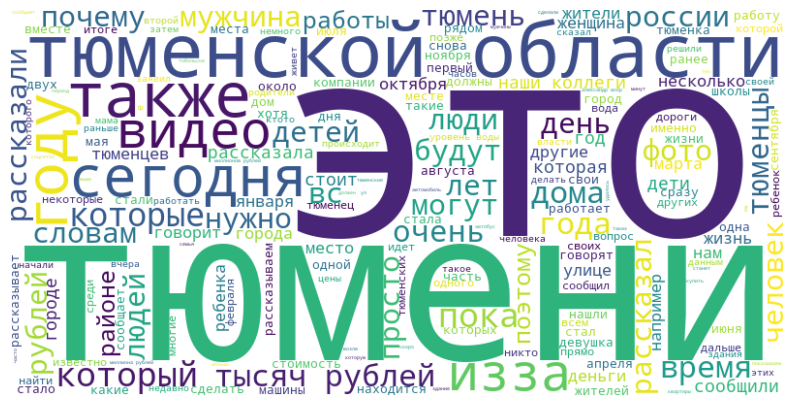

In [48]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Функция для создания облака слов
def plot_wordcloud(text_data):
    # Объединяем все тексты в один строковый объект
    all_text = ' '.join(text_data)
    
    # Создаем объект облака слов
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(all_text)
    
    # Визуализируем облако слов
    plt.figure(figsize=(10, 6))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.show()

# Применяем функцию для всех очищенных текстов в DataFrame
plot_wordcloud(df['cleaned_text'])


C:\Users\Prosc\AppData\Local\Temp\ipykernel_1496\3769258123.py:21: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(words), y=list(counts), palette='viridis')


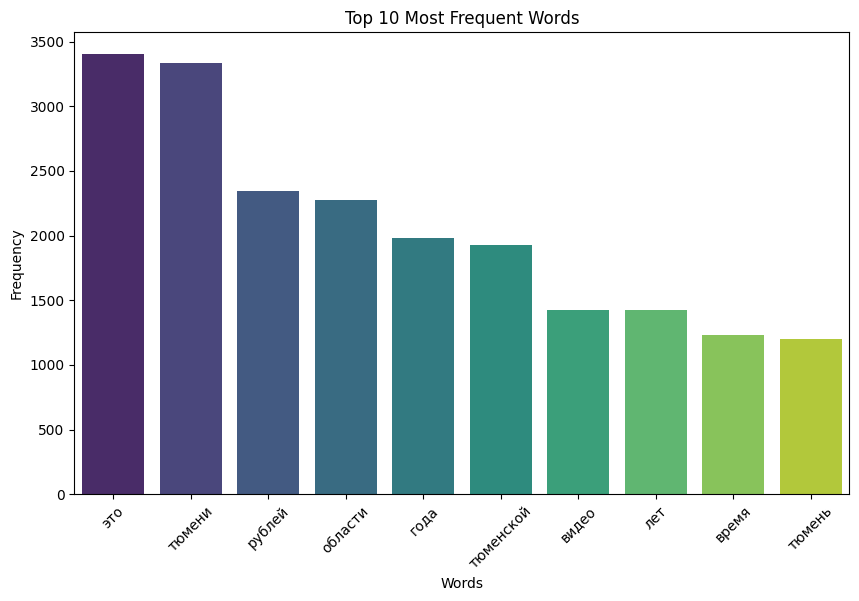

In [49]:
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns

# Функция для частотного анализа слов
def plot_word_frequency(text_data, top_n=10):
    # Объединяем все тексты в одну строку и разбиваем на слова
    all_words = ' '.join(text_data).split()
    
    # Считаем частоту каждого слова
    word_counts = Counter(all_words)
    
    # Получаем топ-N самых популярных слов
    most_common_words = word_counts.most_common(top_n)
    
    # Подготовка данных для графика
    words, counts = zip(*most_common_words)
    
    # Строим график
    plt.figure(figsize=(10, 6))
    sns.barplot(x=list(words), y=list(counts), palette='viridis')
    plt.title(f'Top {top_n} Most Frequent Words')
    plt.xlabel('Words')
    plt.ylabel('Frequency')
    plt.xticks(rotation=45)
    plt.show()

# Применяем функцию для частотного анализа
plot_word_frequency(df['cleaned_text'], top_n=10)


In [ ]:
Больше ничего не придумал
